In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import r2_score
from scipy import stats

from numba import njit
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from trainers import MetaTrainer

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulator settings

In [16]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

In [17]:
class TPrior:
    
    def __init__(self, theta_dim, mu_scale, scale_scale):
        
        self.theta_dim = theta_dim
        self.prior_mu = stats.multivariate_normal(np.zeros(self.theta_dim), mu_scale * np.eye(self.theta_dim))
        self.prior_scale = stats.uniform(0, scale_scale) 
        
    def __call__(self, batch_size):
        """
        Returns a sample from the prior.
        """
        
        mu_samples = self.prior_mu.rvs(batch_size)
        if batch_size == 1:
            mu_samples = mu_samples[np.newaxis]
        scale_samples = self.prior_scale.rvs((batch_size, self.theta_dim))
        return np.c_[mu_samples, scale_samples].astype(np.float32)

In [18]:
class MultivariateT:
    def __init__(self, df=10, seed=42):
        
        self.df = df
        self.seed = seed
        
    def simulate_data(self, p_sample, n_obs):
        """
        Returns a dataset given a sample from the prior.
        """
        
        D = p_sample.shape[0] // 2
        mu, sd = p_sample[:D], p_sample[D:]
        x = stats.multivariate_t(loc = mu, shape = np.diag(sd), df = self.df).rvs(n_obs)
        return x
   

    def generate_multiple_datasets(self, p_samples, n_obs):
        """ Generates multiple datasets through BayesianMultivariateT.generate_data() """
        
        batch_size = p_samples.shape[0]
        theta_dim = p_samples.shape[1] // 2
        x = np.zeros((batch_size, n_obs, theta_dim))
 
        for bi in range(batch_size):
            x[bi] = self.simulate_data(p_samples[bi], n_obs)
        return x.astype(np.float32)
    
    
    def __call__(self, p_samples, n_obs=100):
        """
        Makes instances of the class callable.
        """
        
        return self.generate_multiple_datasets(p_samples, n_obs)

In [73]:
class GenerativeModel:
    def __init__(self, model_prior, priors, simulators, param_transform=None):
        
        self.model_prior = model_prior
        self.priors = priors
        self.simulators = simulators
        self.param_transform = param_transform
        self.n_models = len(self.simulators)

    def __call__(self, n_sim, n_obs, **kwargs):
        """
        Simulates n_sim datasets of n_obs observations from the provided simulator
        ----------

        Arguments:
        n_sim : int -- number of simulation to perform at the given step (i.e., batch size)
        n_obs : int or callable -- if int, then treated as a fixed number of observations, if callable, then
                                   treated as a function for sampling N, i.e., N ~ p(N)
        ----------
        Returns:
        params    : np.array (np.float32) of shape (n_sim, param_dim) -- array of sampled parameters
        sim_data  : np.array (np.float32) of shape (n_sim, n_obs, data_dim) -- array of simulated data sets

        """
        
        # Sample model indices
        model_indices = self.model_prior(n_sim, self.n_models)
        
        # Prepare data and params placeholders
        params = []
        sim_data = []
        
        # Loop for n_sim number of simulations
        for sim_idx in range(n_sim):
            
            # Simulate from model
            params_ = self.priors[model_indices[sim_idx]](1)
            sim_data_ = self.simulators[model_indices[sim_idx]](params_, n_obs, **kwargs)
            
            params.append(params_)
            sim_data.append(sim_data_)
        
        # Convert to numpy arrays
        model_indices = tf.keras.utils.to_categorical(model_indices, self.n_models)
        params = np.concatenate(params, axis=0)
        sim_data = np.concatenate(sim_data, axis=0)

        return model_indices.astype(np.float32), params.astype(np.float32), sim_data.astype(np.float32)

# An example Bayesian workflow (with BayesFlow)

Towards a principled Bayesian workflow for cognitive modeling:

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

https://arxiv.org/abs/1904.12765

## Prior predictive checks

In [74]:
class Permutation(tf.keras.Model):
    """Implements a permutation layer to permute the input dimensions of the cINN block."""

    def __init__(self, input_dim):
        """
        Creates a permutation layer for a conditional invertible block.
        ----------

        Arguments:
        input_dim  : int -- the dimensionality of the input to the c inv block.
        """

        super(Permutation, self).__init__()

        permutation_vec = np.random.permutation(input_dim)
        inv_permutation_vec = np.argsort(permutation_vec)
        self.permutation = tf.Variable(initial_value=permutation_vec,
                                       trainable=False,
                                       dtype=tf.int32,
                                       name='permutation')
        self.inv_permutation = tf.Variable(initial_value=inv_permutation_vec,
                                           trainable=False,
                                           dtype=tf.int32,
                                           name='inv_permutation')

    def call(self, x, inverse=False):
        """Permutes the bach of an input."""

        if not inverse:
            return tf.transpose(tf.gather(tf.transpose(x), self.permutation))
        return tf.transpose(tf.gather(tf.transpose(x), self.inv_permutation))

In [75]:
class InvariantCouplingNet(tf.keras.Model):
    """Implements a conditional version of a sequential network."""

    def __init__(self, meta, n_out):
        """
        Creates a conditional coupling net (FC neural network).
        ----------

        Arguments:
        meta  : list -- a list of dictionaries, wherein each dictionary holds parameter - value pairs for a single
                       tf.keras.Dense layer.
        n_out : int  -- number of outputs of the coupling net
        """

        super(InvariantCouplingNet, self).__init__()
        
        self.h1 = Sequential([Dense(**meta['dense_h1_args']) for _ in range(meta['n_dense_h1'])])
        self.h2 = Sequential(
            [Dense(**meta['dense_h2_args']) for _ in range(meta['n_dense_h2'])] +
            [Dense(n_out)]
        )
        

    def call(self, m, params, x):
        """
        Concatenates x and y and performs a forward pass through the coupling net.
        Arguments:
        m      : tf.Tensor of shape (batch_size, n_models) -- the one-hot-encoded model indices
        params : tf.Tensor of shape (batch_size, theta_dim)  -- the parameters theta ~ p(theta) of interest
        x      : tf.Tensor of shape (batch_size, n_obs, inp_dim) -- the conditional data of interest x
        """
        
        N = int(x.shape[1])
        params_rep = tf.stack([params] * N, axis=1)
        m_rep = tf.stack([m] * N, axis=1)
        x_params_m = tf.concat([x, params_rep, m_rep], axis=-1)
        rep = tf.reduce_mean(self.h1(x_params_m), axis=1)
        rep_params_m = tf.concat([rep, params, m], axis=-1)
        out = self.h2(rep_params_m)
        return out

In [76]:
class ConditionalCouplingLayer(tf.keras.Model):
    """Implements a conditional version of the INN block."""

    def __init__(self, meta):
        """
        Creates a conditional invertible block.
        ----------

        Arguments:
        meta      : list -- a list of dictionaries, wherein each dictionary holds parameter - value pairs for a single
                       tf.keras.Dense layer. All coupling nets are assumed to be equal.
        """

        super(ConditionalCouplingLayer, self).__init__()
        self.alpha = meta['alpha']
        theta_dim = meta['n_params']
        self.n_out1 = theta_dim // 2
        self.n_out2 = theta_dim // 2 if theta_dim % 2 == 0 else theta_dim // 2 + 1
        if meta['permute']:
            self.permutation = Permutation(theta_dim)
        else:
            self.permutation = None
            
        self.s1 = InvariantCouplingNet(meta['s_args'], self.n_out1)
        self.t1 = InvariantCouplingNet(meta['t_args'], self.n_out1)
        self.s2 = InvariantCouplingNet(meta['s_args'], self.n_out2)
        self.t2 = InvariantCouplingNet(meta['t_args'], self.n_out2)

    def call(self, m, params, x, inverse=False, log_det_J=True):
        """
        Implements both directions of a conditional invertible block.
        ----------

        Arguments:
        m         : tf.Tensor of shape (batch_size, n_models) -- the one-hot-encoded model indices
        theta     : tf.Tensor of shape (batch_size, theta_dim) -- the parameters theta ~ p(theta|y) of interest
        x         : tf.Tensor of shape (batch_size, summary_dim) -- the summarized conditional data of interest x = sum(x)
        inverse   : bool -- flag indicating whether to tun the block forward or backwards
        log_det_J : bool -- flag indicating whether to return the log determinant of the Jacobian matrix
        ----------

        Returns:
        (v, log_det_J)  :  (tf.Tensor of shape (batch_size, inp_dim), tf.Tensor of shape (batch_size, )) --
                           the transformed input, if inverse = False, and the corresponding Jacobian of the transformation
                            if inverse = False
        u               :  tf.Tensor of shape (batch_size, inp_dim) -- the transformed out, if inverse = True
        """

        # --- Forward pass --- #
        if not inverse:

            if self.permutation is not None:
                params = self.permutation(params)

            u1, u2 = tf.split(params, [self.n_out1, self.n_out2], axis=-1)

            # Pre-compute network outputs for v1
            s1 = self.s1(m, u2, x)
            # Clamp s1 if specified
            if self.alpha is not None:
                s1 = (2. * self.alpha / np.pi) * tf.math.atan(s1 / self.alpha)
            t1 = self.t1(m, u2, x)
            v1 = u1 * tf.exp(s1) + t1

            # Pre-compute network outputs for v2
            s2 = self.s2(m, v1, x)
            # Clamp s2 if specified
            if self.alpha is not None:
                s2 = (2. * self.alpha / np.pi) * tf.math.atan(s2 / self.alpha)
            t2 = self.t2(m, v1, x)
            v2 = u2 * tf.exp(s2) + t2
            v = tf.concat((v1, v2), axis=-1)

            if log_det_J:
                # log|J| = log(prod(diag(J))) -> according to inv architecture
                return v, tf.reduce_sum(s1, axis=-1) + tf.reduce_sum(s2, axis=-1)
            return v

        # --- Inverse pass --- #
        else:

            v1, v2 = tf.split(params, [self.n_out1, self.n_out2], axis=-1)

            # Pre-Compute s2
            s2 = self.s2(m, v1, x)
            # Clamp s2 if specified
            if self.alpha is not None:
                s2 = (2. * self.alpha / np.pi) * tf.math.atan(s2 / self.alpha)
            u2 = (v2 - self.t2(m, v1, x)) * tf.exp(-s2)

            # Pre-Compute s1
            s1 = self.s1(m, u2, x)
            # Clamp s1 if specified
            if self.alpha is not None:
                s1 = (2. * self.alpha / np.pi) * tf.math.atan(s1 / self.alpha)
            u1 = (v1 - self.t1(m, u2, x)) * tf.exp(-s1)
            u = tf.concat((u1, u2), axis=-1)

            if self.permutation is not None:
                u = self.permutation(u, inverse=True)
            return u


class InvariantBayesFlow(tf.keras.Model):
    """Implements a chain of conditional invertible blocks for Bayesian parameter inference."""

    def __init__(self, meta):
        """
        Creates a chain of cINN blocks and chains operations.
        ----------

        Arguments:
        meta        : list -- a list of dictionary, where each dictionary holds parameter - value pairs for a single
                                  keras.Dense layer
        """

        super(InvariantBayesFlow, self).__init__()

        self.cINNs = [ConditionalCouplingLayer(meta) for _ in range(meta['n_coupling_layers'])]
        self.z_dim = meta['n_params']
        self.n_models = meta['n_models']

    def call(self, m, params, x, inverse=False):
        """
        Performs one pass through an invertible chain (either inverse or forward).
        ----------

        Arguments:
        m         : tf.Tensor of shape (batch_size, n_models) -- the one-hot-encoded model indices
        params    : tf.Tensor of shape (batch_size, inp_dim) -- the parameters theta ~ p(theta|x) of interest
        x         : tf.Tensor of shape (batch_size, summary_dim) -- the conditional data x
        inverse   : bool -- flag indicating whether to tun the chain forward or backwards
        ----------

        Returns:
        (z, log_det_J)  :  (tf.Tensor of shape (batch_size, inp_dim), tf.Tensor of shape (batch_size, )) --
                           the transformed input, if inverse = False, and the corresponding Jacobian of the transformation
                            if inverse = False
        x               :  tf.Tensor of shape (batch_size, inp_dim) -- the transformed out, if inverse = True
        """
        

        if inverse:
            return self.inverse(m, params, x)
        else:
            return self.forward(m, params, x)

    def forward(self, m, params, x):
        """Performs a forward pass though the chain."""

        z = params
        log_det_Js = []
        for cINN in self.cINNs:
            z, log_det_J = cINN(m, z, x)
            log_det_Js.append(log_det_J)
        # Sum Jacobian determinants for all blocks to obtain total Jacobian.
        log_det_J = tf.add_n(log_det_Js)
        return z, log_det_J

    def inverse(self, m, z, x):
        """Performs a reverse pass through the chain."""

        params = z
        for cINN in reversed(self.cINNs):
            params = cINN(m, params, x, inverse=True)
        return params

    def sample(self, x, m, n_samples, to_numpy=True):
        """
        Samples from the inverse model given a single instance x.
        ----------

        Arguments:
        x         : tf.Tensor of shape (n_obs, x_dim) -- the conditioning data of interest
        m         : int - the integer model index
        n_samples : int -- number of samples to obtain from the approximate posterior
        to_numpy  : bool -- flag indicating whether to return the samples as a np.array or a tf.Tensor
        ----------

        Returns:
        theta_samples : 3D tf.Tensor or np.array of shape (n_samples, n_batch, theta_dim)
        """
        
        # Represent model index
        m_oh = tf.stack([tf.keras.utils.to_categorical(m, self.n_models)] * n_samples, axis=0)
        
        # Sample in parallel
        z_normal_samples = tf.random.normal(shape=(n_samples, self.z_dim), dtype=tf.float32)
        theta_samples = self.inverse(m_oh, z_normal_samples, tf.stack([x] * n_samples, axis=0))

        if to_numpy:
            return theta_samples.numpy()
        return theta_samples

In [77]:
def kl_latent_space(network, model_indices, params, sim_data):
    """
    #TODO - Make sure that connectors know the loss structure AND network structure
    ----------

    Arguments:
    network       : tf.keras.Model -- a single model amortizer
    model_indices : tf.Tensor or np.ndarray (n_sim, ) or (n_sim, n_models) -- the true model indices
    params        : tf.Tensor or np.ndarray of shape (batch_size, n_params) -- data-generating params, as sampled from prior
    sim_data      : tf.Tensor of or np.ndarray shape (batch_size, n_obs, data_dim)  -- synthetic data sets generated by the params
    ----------

    Returns:
    loss : tf.Tensor of shape (,) -- a single scalar value representing the KL loss
    """
    
    z, log_det_J = network(model_indices, params, sim_data)
    loss = tf.reduce_mean(0.5 * tf.square(tf.norm(z, axis=-1)) - log_det_J)
    return loss

In [24]:
def true_vs_estimated(theta_true, theta_est, param_names,
                      figsize=(20, 4), show=True, filename=None, font_size=12):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""


    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Determine figure layout
    if len(param_names) >= 6:
        n_col = int(np.sqrt(len(param_names)))
        n_row = int(np.sqrt(len(param_names))) + 1
    else:
        n_col = int(len(param_names))
        n_row = 1

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat
        
    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(param_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_est[:, j], theta_true[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSE
        rmse = np.sqrt(np.mean( (theta_est[:, j] - theta_true[:, j])**2 ))
        nrmse = rmse / (theta_true[:, j].max() - theta_true[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        # Compute R2
        r2 = r2_score(theta_true[:, j], theta_est[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes, 
                     size=10)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('Estimated')
            axarr[j].set_ylabel('True')
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()

    if show:
        plt.show()

    if filename is not None:
        f.savefig(filename)

## Train amortized estimator

In [111]:
D = 100
J = 10


bf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'n_dense_h1': 2,
        'n_dense_h2': 3,
        'dense_h1_args': {'units': 64, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform'},
        'dense_h2_args': {'units': 128, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform'},
    },
    't_args': {
        'n_dense_h1': 2,
        'n_dense_h2': 3,
        'dense_h1_args': {'units': 64, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform'},
        'dense_h2_args': {'units': 128, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform'},
    },
    'n_params': D,
    'n_models': J,
    'alpha': 1.85,
    'permute': True
}


mu_scale = 1.0
scale_scale = 5.0
df = 10


prior = TPrior(D//2, mu_scale, scale_scale)

In [112]:
priors = [prior] * J
simulators = [MultivariateT(df) for df in np.arange(1, 101, J)]

In [113]:
generator = GenerativeModel(model_prior, priors, simulators)

In [114]:
meta_amortizer = InvariantBayesFlow(bf_meta)

In [116]:
# Generate some training data
m_indices, params_m, sim_data = generator(n_sim=20000, n_obs=100)

In [104]:
# Create a trainer instance
trainer = MetaTrainer(meta_amortizer, 
                      generator, 
                      kl_latent_space, 
                      checkpoint_path='meta3', 
                      learning_rate=0.0003)

Initializing networks from scratch.


In [105]:
# %%time
losses = trainer.train_offline(25, 32, m_indices, params_m, sim_data)

Converting 20000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/625 [00:00<?, ?it/s]

In [106]:
# Generate some training data
m_indices_val, params_m_val, sim_data_val = generator(n_sim=300, n_obs=100)

In [107]:
# Sample posterior for each test data set, otherwise GPU memory blows 
# when attempted in parallel for all test sets
samples = []
for i in range(300):
    samples.append(meta_amortizer.sample(sim_data_val[i], m_indices_val[i].argmax(), n_samples=1000).mean(0))
samples = np.array(samples)

ValueError: Input 0 of layer sequential_124 is incompatible with the layer: expected axis -1 of input shape to have value 200 but received input with shape (1000, 100, 110)

In [55]:
samples.shape

(300, 100)

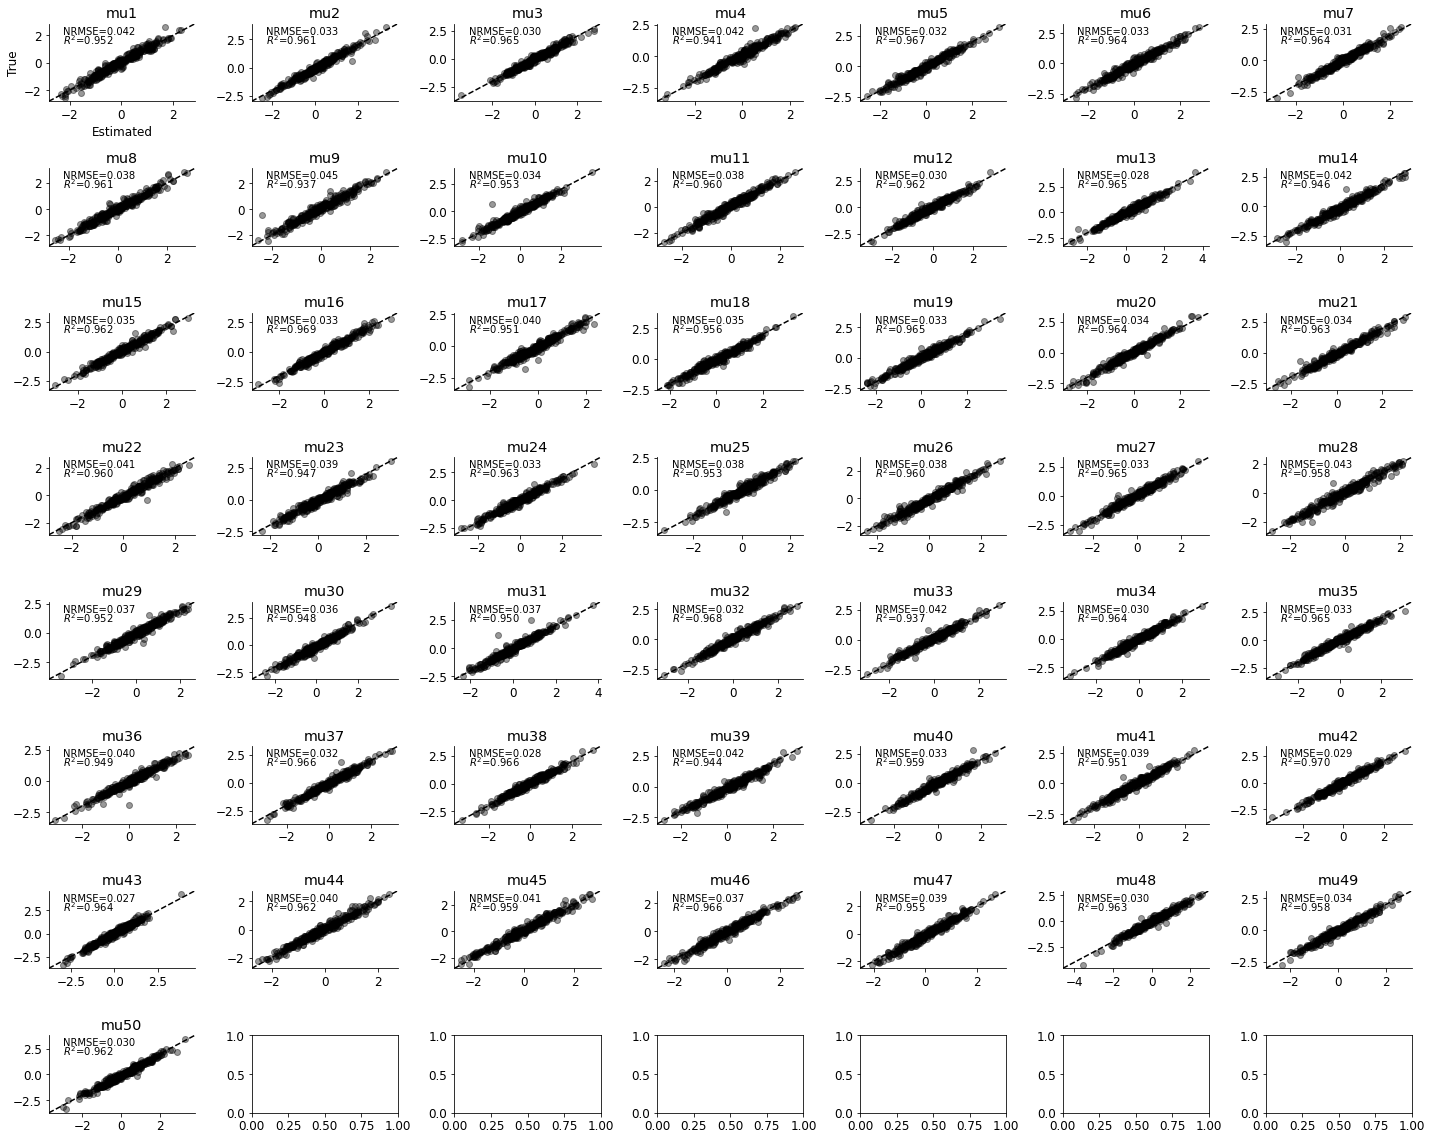

In [56]:
# param_means = samples.mean(axis=0)
true_vs_estimated(params_m_val[:, :50], 
                  samples[:, :50], 
                  ['mu{}'.format(i) for i in range(1, 51)], figsize=(20, 16))

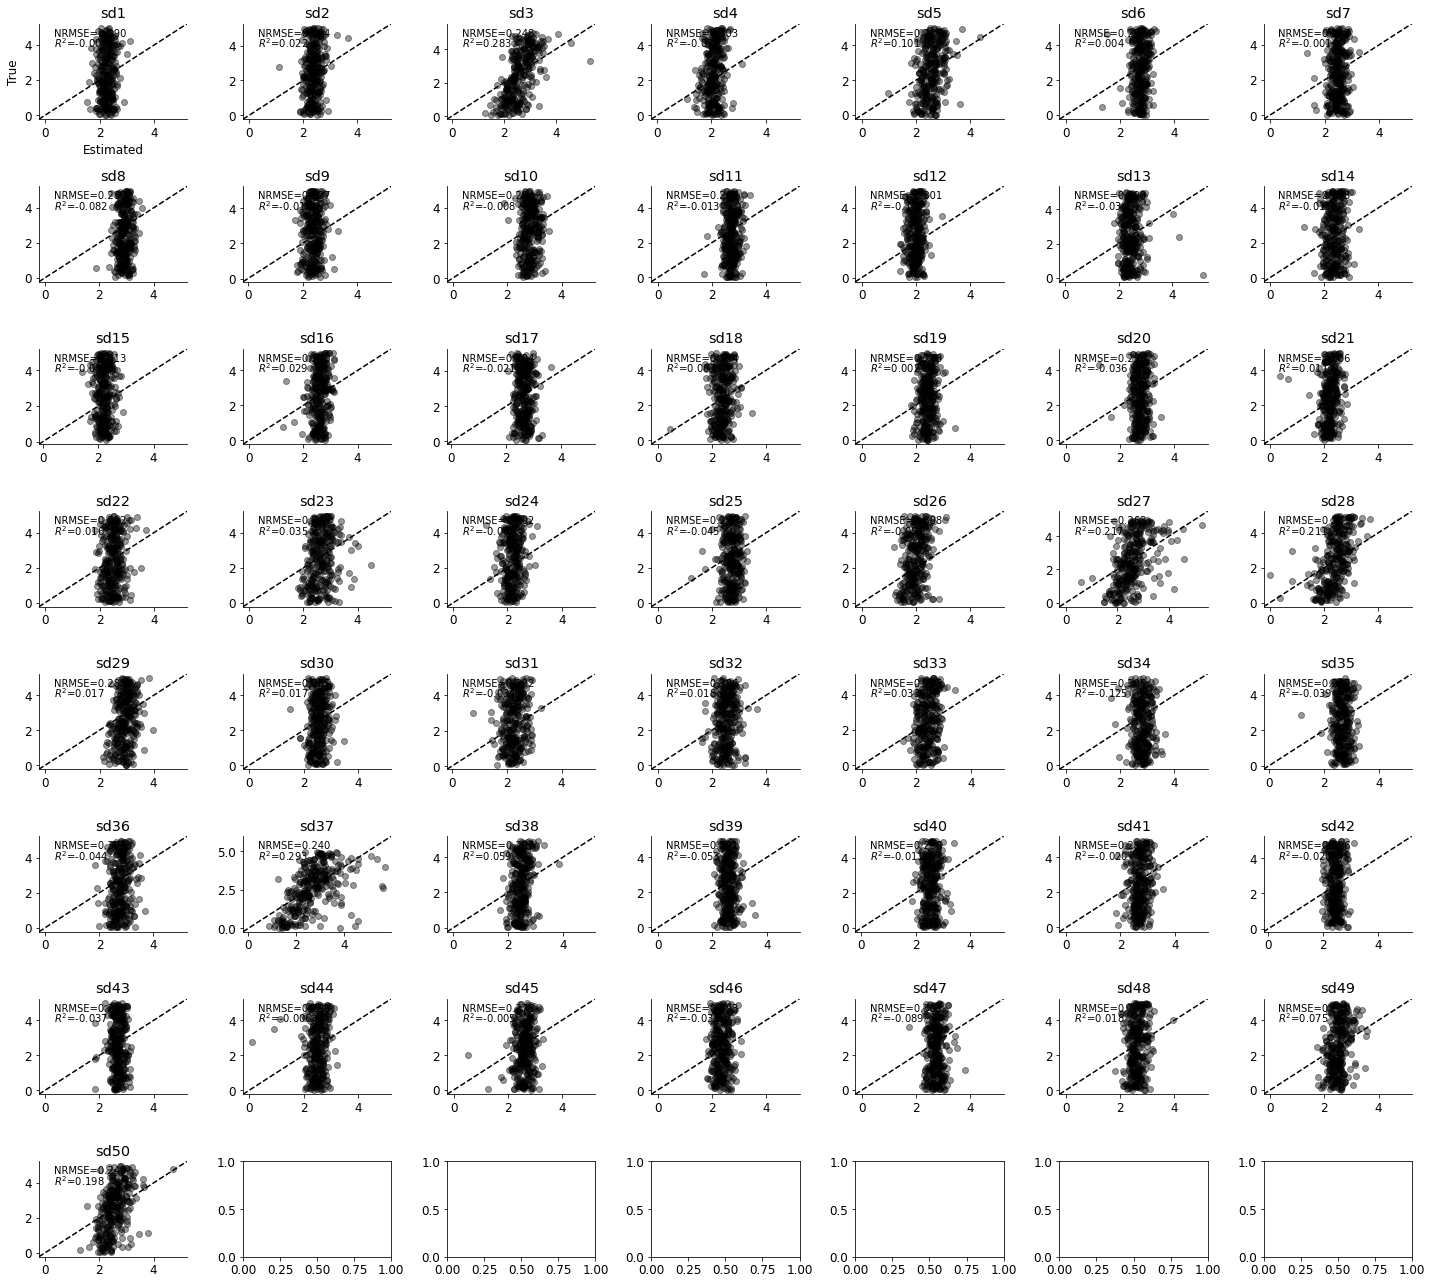

In [57]:
# param_means = samples.mean(axis=0)
true_vs_estimated(params_m_val[:, 50:], 
                  samples[:, 50:], 
                  ['sd{}'.format(i) for i in range(1, 51)], figsize=(20, 18))

In [69]:
# # %%time
# trainer.train_online(10, 1000, 32)

## Compuational faithfulness
(Via simulation-based calibration)

In [50]:
n_sbc = 5000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc)
param_samples = np.concatenate([bayes_flow.sample(x, n_post_samples_sbc) 
                                for x in tf.split(x_sbc, 10, axis=0)], axis=1)

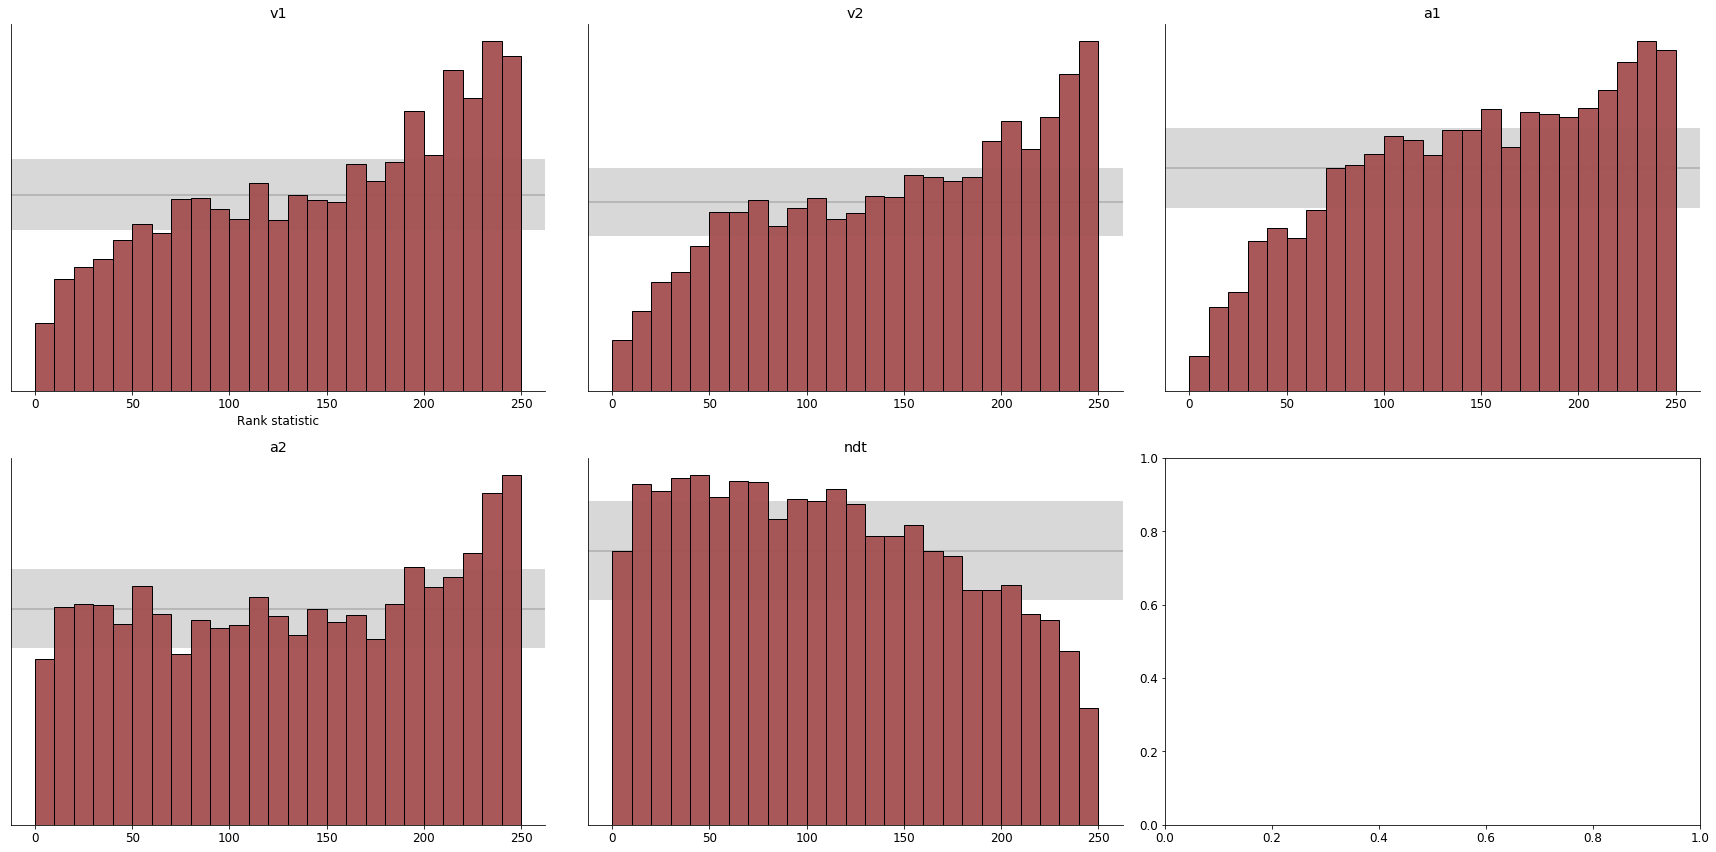

In [52]:
plot_sbc(param_samples, params_sbc, param_names=['v1', 'v2', 'a1', 'a2', 'ndt'])

## Model sensitivity/adequacy

### Quick and dirty

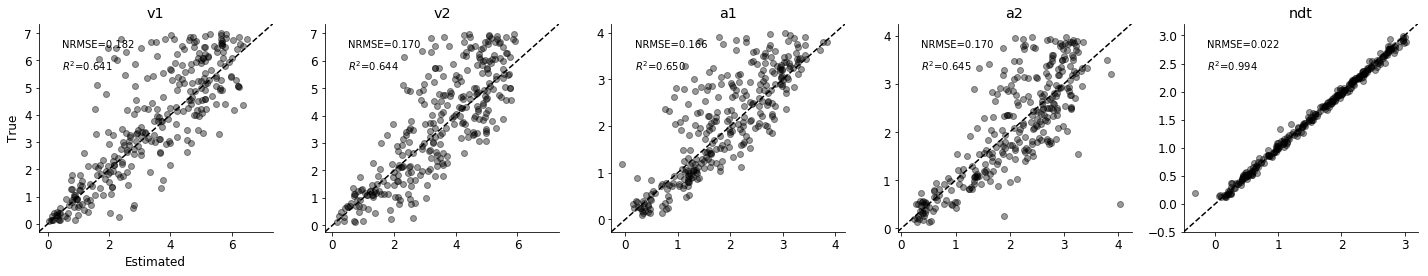

In [49]:
# Validate (quick and dirty)
true_params = prior(300)
x = batch_simulator(true_params).astype(np.float32)
param_samples = bayes_flow.sample(x, n_samples=1000)
param_means = param_samples.mean(axis=0)
true_vs_estimated(true_params, param_means, ['v1', 'v2', 'a1', 'a2','ndt'])

### A Bayesian eyechart

In [ ]:
# Simulate
n_sim_s = 500
n_samples_posterior = 1000
true_params = prior(n_sim_s)
x = batch_simulator(true_params)

# Sample from posterior
param_samples = bayes_flow.sample(x, n_samples_posterior)

### Posterior z-score
# Compute posterior means and stds
post_means = param_samples.mean(0)
post_stds = param_samples.std(0)
post_vars = param_samples.var(0)

# Compute posterior z score
post_z_score = (post_means - true_params) / post_stds

### Posterior contraction, i.e., 1 - post_var / prior_var
prior_a = (0.1, 0.1, 0.1, 0.1, 0.1) # lower bound of uniform prior
prior_b = (7.0, 7.0, 4.0, 4.0, 3.0) # upper bound of uniform prior

# Compute prior vars analytically
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
post_cont = 1 - post_vars / prior_vars

# Plotting time
f, axarr = plt.subplots(2, 3, figsize=(12, 6))
for i, (p, ax) in enumerate(zip(param_names, axarr.flat)):
    

    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z-score', fontsize=14)
f.tight_layout()

## Posterior postdictive/predictive checks